In [1]:
!pwd

/opt/ml/input/code


In [2]:
# !pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
# from autocorrect import Speller
# import nltk
# nltk.download('punkt') => 이거까진 필요없어

In [61]:
users_origin = pd.read_csv('./data/users.csv')
books_origin = pd.read_csv("./data/books.csv", encoding='utf-8')
ratings_origin = pd.read_csv('./data/train_ratings.csv')
test_origin = pd.read_csv('./data/test_ratings.csv')

In [4]:
users = pd.read_csv('./data/users.csv')
books = pd.read_csv("./data/books.csv", encoding='utf-8')
ratings = pd.read_csv('./data/train_ratings.csv')
test = pd.read_csv('./data/test_ratings.csv')

In [5]:
def text_preprocessing_func(text : str ) -> str :
    """
    깨진 문자를 변환하는 함수
    """
    text = text.replace('Ã?Â©','e') # 원래는 é인데 걍 e로 메움
    text = text.replace('Ã©', 'e')
    text = text.replace('Ã?Â?','e') # 원래는 é인데 걍 e로 메움
    text = text.lower()
    return text

In [6]:
users

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0
...,...,...,...
68087,278376,"danville, pennsylvania, usa",54.0
68088,278621,"victoria, delaware, canada",74.0
68089,278636,"irvington, alabama, usa",NaN
68090,278659,"vancouver, washington, usa",33.0


# USERS
- AGE column은 삭제합니다

In [7]:
users['user_id'].nunique()

68092

#### AGE COLUMN 삭제

In [8]:
users.isna().sum()

user_id         0
location        0
age         27833
dtype: int64

In [9]:
users = users.drop('age', axis=1)

## LOCATION
- location state, city, country 가 na인 row들 날려줌
- location country 이상한 애들 직접 확인해서 수정
- location, location city column 삭제
- location state는 원하는대로 결정하기

In [10]:
# USERS에서 location을 location country, city, state로 나눠줌

users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass
    
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

/tmp/ipykernel_17913/1343807041.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거


In [11]:
users.isna().sum()

user_id                0
location               0
location_city        122
location_state      1132
location_country     271
dtype: int64

#### location state, city, country가 na인 애들 날려줌 (왜냐! 몇개없음)

In [12]:
users = users.dropna(subset=['location_state', 'location_city', 'location_country']).reset_index(drop=True)

#### locationcolumn도 날려줌 (분리했으니까)

In [13]:
users = users.drop('location', axis=1)

### location country에서 이상한 애들 확인

In [14]:
min(users['location_country'].apply(len))

1

#### location_country가 이상한 애들은 직접 수정해드렸습니다^^

In [15]:
users[users['location_country'].apply(len)==1]

,user_id,location_city,location_state,location_country
44506,41195,c,c,c


In [16]:
# 너무 더러운데.. 어쩌지
users[users['location_country']=='']

,user_id,location_city,location_state,location_country


In [17]:
country_fix_dict = {'usa': {'oklahoma','districtofcolumbia', 'connecticut', 'worcester', 'aroostook', 'texas',  'kern', 'orangeco', 'unitedstatesofamerica', 'fortbend', 'alachua', 'massachusetts', 'arizona', 'austin', 'hawaii', 'ohio', 'camden', 'arkansas', 'minnesota', 'losestadosunidosdenorteamerica', 'us', 'usanow', 'northcarolina', 'maine', 'colorado','oklahoma', 'alabama', 'anystate', 'districtofcolumbia', 'unitedstaes', 'pender', 'newhampshire', 'unitedstates', 'missouri', 'idaho', 'ca', 'newyork','tennessee', 'stthomasi', 'dc', 'washington', 'illinois', 'california', 'michigan', 'iowa', 'maryland', 'newjersey', 'vanwert', 'oregon'},
                    'uk': {'alderney', 'wales',  'aberdeenshire', 'bermuda', 'nottinghamshire', 'scotland', 'usacurrentlylivinginengland', 'england', 'countycork', 'alderney', 'cambridgeshire', 'middlesex', 'northyorkshire', 'westyorkshire', 'cocarlow', 'sthelena'},
                    'japan': {'okinawa'},
                    'southkorea': {'seoul'},
                    'canada': {'ontario', 'alberta', 'novascotia', 'newfoundland', 'newbrunswick', 'britishcolumbia'},
                    'miyanma': {'burma'},
                    'newzealand': {'auckland', 'nz', 'otago'},
                    'spain': {'andalucia','pontevedra', 'gipuzkoa', 'lleida', 'catalunyaspain', 'galiza', 'espaa'},
                    'germany': {'niedersachsen', 'deutschland'},
                    'brazil': {'disritofederal'},
                    'switzerland': {'lasuisse'},
                    'italy': {'veneziagiulia', 'ferrara', 'italia'},
                    'australia': {'nsw', 'queensland', 'newsouthwales'},
                    'belgium': {'labelgique', 'bergued'},
                    'uruguay': {'urugua'},
                    'panama': {'republicofpanama'}
                   }
country_del_list = ['c', 'space', 'universe', 'unknown', 'quit', 'tdzimi', 'universe', 'tn', 'unknown', 'space', 'c', 'franciscomorazan', 'petrolwarnation', 'ineurope', 'hereandthere', 'faraway']

In [18]:
users

,user_id,location_city,location_state,location_country
0,8,timmins,ontario,canada
1,11400,ottawa,ontario,canada
2,67544,toronto,ontario,canada
3,85526,victoria,britishcolumbia,canada
4,96054,ottawa,ontario,canada
...,...,...,...,...
66798,278376,danville,california,usa
66799,278621,victoria,delaware,canada
66800,278636,irvington,alabama,usa
66801,278659,vancouver,britishcolumbia,canada


In [19]:
del_idx = []
for idx, row in enumerate(users['location_country']):
    for key, value in country_fix_dict.items():
        if row in value:
            users.at[idx, 'location_country'] = key
    if row in country_del_list:
        del_idx.append(idx)

In [20]:
users = users.drop(del_idx, axis=0).reset_index(drop=True)

#### location_state 맛만 보겠습니다

In [21]:
users['location_state'].value_counts()

california         6873
ontario            2504
texas              2504
newyork            2398
england            2230
                   ... 
grancanaria           1
vallsoccidental       1
soria                 1
galway                1
ccp                   1
Name: location_state, Length: 1298, dtype: int64

#### location_city 날립니다
- location_state를 날리고 싶다면 알아서 하세요

In [22]:
# 날릴까 말까 => state를 날리고 싶다면 주석 푸세요
# users = users.drop('location_state', axis=1)
users = users.drop('location_city', axis=1)

In [23]:
users

,user_id,location_state,location_country
0,8,ontario,canada
1,11400,ontario,canada
2,67544,ontario,canada
3,85526,britishcolumbia,canada
4,96054,ontario,canada
...,...,...,...
66785,278376,california,usa
66786,278621,delaware,canada
66787,278636,alabama,usa
66788,278659,britishcolumbia,canada


# BOOKS
- summary : 날리자! 사유는 언어가 다 다른데 이거 모델에 넣고 돌리기 too much 노동 크롤링 하면 안 되니까 할 수 없다..가 의견입니다.
- year_of_publication : float -> int
- category : 보류
- language : isbn 코드로 채워주자
  https://en.wikipedia.org/wiki/List_of_ISBN_registration_groups

In [24]:
# float이라서 int로 바꿔줌
books['year_of_publication'] = books['year_of_publication'].astype(int)

## Summary 삭제

In [25]:
books = books.drop('summary', axis=1) ; books

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],images/0425176428.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...
149565,067161746X,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987,Pocket Books,http://images.amazon.com/images/P/067161746X.0...,en,['Humor'],images/067161746X.01.THUMBZZZ.jpg
149566,0767907566,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,en,['Nature'],images/0767907566.01.THUMBZZZ.jpg
149567,0884159221,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,NaN,NaN,images/0884159221.01.THUMBZZZ.jpg
149568,0912333022,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,en,['Fiction'],images/0912333022.01.THUMBZZZ.jpg


## category
- category high로 묶어주기
- category null값 book_title, book_author 같을 때 na 아닌 거 있으면 걔로 채워넣어주기

In [ ]:
# 일단 category에서 대괄호 밖으로 빼기
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 소문자로 바꾸기
books['category'] = books['category'].str.lower()

##### category_high

In [158]:
# 카테고리를 좀 더 큰 카테고리로 묶어주자
books['category_high'] = books['category'].copy()

In [159]:
# category에 history가 들어가는 애들은 다 history로 묶어주기
books.loc[books[books['category'].str.contains('history',na=False)].index,'category_high'] = 'history'

In [243]:
books['category'].value_counts().tail(40)

unix computer file                                 1
romania                                            1
aeronautics military                               1
icarian community                                  1
bisexuality                                        1
glasnost                                           1
asp computer network protocol                      1
buddhists                                          1
voyages around the world                           1
brichter peter fictitious character                1
baltimore metropolitan area md                     1
afrikaners                                         1
fugitives from justice                             1
maigret jules fictitious character                 1
miracles                                           1
pharmaceutical industry                            1
friendships                                        1
birth customs                                      1
electronic journals                           

In [244]:
categories = ['history', 'fiction', 'nonfiction','physics','adventure','fiction','nonfiction','science','science fiction',
 'jouvenile fiction', 'jouvenille nonfiction','disease','mathemat','agricult',
 'business','poetry','drama','literary','travel','motion picture','children','literature','electronic',
 'humor','computer','house','family','architect','camp','language', 'comic', 'sports', 'novel']
groupings = {'hobby' : ['crafts', 'hobbies', 'hobby', 'garden'],
             'art/media' : ['art', 'photograph', 'music'],
             'house/cook' : ['cook', 'house'],
             'business' : ['economics', 'business'],
             'religion' : ['christian', 'bible', 'religion'],
             'animal' : ['animal', 'bird'],
             'social science' : ['philosophy', 'psycholog', 'social', 'sociology'],
             'criminal' : ['criminal', 'homicide'],
             'eco' : ['ecology', 'environment', 'nature']}

In [245]:
grouping_values = [value for lists in groupings.values() for value in lists]

In [260]:
# 상위 카테고리 묶기
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category
# grouping 하기
for value in grouping_values:
    books.loc[books[books['category'].str.contains(value, na = False)].index, 'category_high'] = groupings[value]

KeyError: 'crafts'

In [257]:
books['category'].str.contains(grouping_values[0], na = False)

0         False
1         False
2         False
3         False
4         False
          ...  
149565    False
149566    False
149567    False
149568    False
149569    False
Name: category, Length: 149570, dtype: bool

##### category null 값 묶기

In [28]:
books['category_new'] = books['category_high'].copy()
books['category_new'] = books['category_new'].fillna('0')

In [29]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
img_path                   0
category_high          68851
category_new               0
dtype: int64

In [30]:
tmp = books.groupby(['book_title', 'book_author'])['category_new'].apply(lambda x : ' / '.join(x)).to_frame()

In [31]:
tmp.reset_index(drop=False)['category_new'].value_counts().tail(20)

avarice / chocolate / fiction / fiction / 0 / 0                                        1
pets / biography autobiography                                                         1
health fitness / others                                                                1
0 / 0 / fiction / fiction / others / 0 / nonfiction / 0 / 0 / fiction / fiction / 0    1
0 / fiction / 0 / 0 / children                                                         1
0 / adultery                                                                           1
fiction / ghost stories                                                                1
spiritual life / religion / religion                                                   1
african americans / social                                                             1
0 / humor / humor                                                                      1
fiction / magic                                                                        1
0 / 0 / history / 0 /

In [32]:
tmp = tmp.reset_index(drop=False) ; tmp

,book_title,book_author,category_new
0,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,fiction
1,"Ask Lily (Young Women of Faith: Lily Series, ...",Nancy N. Rue,fiction
2,Dark Justice,Jack Higgins,fiction
3,Earth Prayers From around the World: 365 Pray...,Elizabeth Roberts,0
4,Final Fantasy Anthology: Official Strategy Gu...,David Cassady,games
...,...,...,...
139500,Ã?Â?bernachten mit Stil. Die schÃ?Â¶nsten Coun...,Christopher Fennel,0
139501,Ã?Â?rger mit Produkt X. Roman.,Joan Aiken,0
139502,Ã?Â?sterlich leben.,Anselm GrÃ?Â¼n,0
139503,Ã?Â?stlich der Berge.,David Guterson,0


## Book_title
- 글자 깨진거 수정, 소문자처리

In [55]:
books['book_title'] = books['book_title'].apply(text_preprocessing_func)

In [56]:
books['book_title']

0                                              clara callan
1                                      decision in normandy
2         flu: the story of the great influenza pandemic...
3                                    the kitchen god's wife
4         what if?: the world's foremost military histor...
                                ...                        
149565    the bachelor home companion: a practical guide...
149566    all elevations unknown: an adventure in the he...
149567    why stop?: a guide to texas historical roadsid...
149568    the are you being served? stories: 'camping in...
149569    dallas street map guide and directory, 2000 ed...
Name: book_title, Length: 149570, dtype: object

## publisher
- 기본 텍스트 전처리
- 유명 출판사의 경우 표기 방법의 차이 및 오타로 인해같은 그룹으로 묶이지 못하는 항목들이 있으므로 이런 항목들을 수정 => 기본 EDA 코드 활용

In [66]:
# 기본 텍스트 전처리
books['publisher'] = books['publisher'].apply(text_preprocessing_func)

In [67]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [68]:
books_origin['publisher'].nunique(), books['publisher'].nunique()

(11571, 1504)

## Language -> Country
- isbn으로 언어를 출판 국가로 바꿔줍니다

In [117]:
isbn_dict = {}
isbn_dict = { books['language'][idx] : [isbn[:3]] if books['language'][idx] not in isbn_dict.keys() else isbn_dict[books['language'][idx]].append(isbn[:2]) for idx, isbn in enumerate(books['isbn'])}

In [118]:
isbn_dict

{'en': ['091'],
 nan: ['156'],
 'de': ['349'],
 'fr': ['225'],
 'es': ['843'],
 'ca': ['848'],
 'it': ['880'],
 'da': ['344'],
 'nl': ['902'],
 'pt': ['972'],
 'ro': ['359'],
 'no': ['820'],
 'ms': ['186'],
 'la': ['052'],
 'ru': ['140'],
 'el': ['158'],
 'zh-CN': ['081'],
 'th': ['014'],
 'gl': ['848'],
 'ja': ['477'],
 'fa': ['964'],
 'eo': ['084'],
 'gd': ['084'],
 'ga': ['185'],
 'vi': ['080'],
 'zh-TW': ['068'],
 'ko': ['043']}

In [142]:
isbn_code = {'0' : 'english', '1' : 'english', '2': 'franch', '3' : 'german', '4' : 'japan', '5' : 'russia', '7' : 'china',
             '65' : 'brazil', '80' : 'czecho', '81' : 'india', '82' : 'norway', '83' : 'poland', '84' : 'espanol', '85' : 'brazil', '86' : 'yugoslavia', '87' : 'danish', '88' : 'italy', '89' : 'korean', '90' : 'netherlands', '91' : 'sweden',
            '92' : 'international ngo', '93' : 'inida', '94' : 'netherlands', '600' : 'iran', '601' : 'kazakhstan', '602' : 'indonesia', '603' : 'saudi arabia', '604' : 'vietnam', '605' : 'turkey',
            '606' : 'romania', '607' : 'mexico', '608' : 'north macedonia', '609' : 'lithuania', '611' : 'thailand', '612' : 'peru', '613' : 'mauritius',
            '614' : 'lebanon', '615' : 'hungary', '616' : 'thailand', '617' : 'ukraine', '618' : 'greece', '619' : 'bulgaria', '620' : 'mauritius', '621' : 'phillippines',
            '622' : 'iran', '623' : 'indonesia', '624' : 'sri lanka', '625' : 'turkey', '626' : 'taiwan', '627' : 'pakistan', '628' : 'colombia', '629' : 'malaysia', '630' : 'romania',
            '950' : 'argentina', '951' : 'finland', '952' : 'finland', '953' : 'croatia', '954' : 'bulgaria', '955' : 'sri lanka',
            '956' : 'chile', '957' : 'taiwan', '958' : 'colombia', '959' : 'cuba', '960' : 'greece' , '961' : 'slovenia', '962' : 'hong kong',
            '963' : 'hungary', '964' : 'iran', '965' : 'israel', '966' : 'urkaine', '967' : 'malaysia', '968' : 'mexico', '969' : 'pakistan', '970' : 'mexico',
            '971' : 'phillippines', '972' : 'portugal', '973' : 'romania', '974' : 'thailand', '975' : 'turkey', '976' : 'caribbean community', '977' : 'egypt', '978' : 'nigeria', 
            '979' : 'indonesia', '980' : 'venezuela', '981' : 'singapore', '982' : 'south pacific', '983' : 'malaysia', '984' : 'bangladesh', '985' : 'velarus', '986' : 'taiwan',
            '987' : 'argentina', '988' : 'hong kong', '989' : 'portugal',
            '9960':'saudi arabia', '9963' : 'cyprus', '9968' : 'costa rica', '9971' : 'singapore', '9972' : 'peru', '9974' : 'uruguay',
            '9976' : 'tanzania', '9977' : 'costa rica', '9979' : 'iceland', '9986' : 'lithuania',
            '99903' : 'mauritius', '99905' : ' bolivia', '99909' : 'malta', '99912' : 'botswana', '99920' : 'andorra', '99928' : 'georgia',
            '99935' : 'haiti', '99936' : 'bhutan', '99942' : 'armenia', '99943' : 'albania', '99974' : 'bolivia',
            '99975' : 'mongolia', '99989' : 'paraguay'}

In [146]:
check_list = []
books['isbn_country'] = 'na'
for idx in range(len(books)):
    isbn = books['isbn'][idx][:5]
    if isbn[0] in isbn_code.keys():
        books.at[idx, 'isbn_country'] = isbn_code[isbn[0]]
    elif isbn[:2] in isbn_code.keys():
        books.at[idx, 'isbn_country'] = isbn_code[isbn[0:2]]
    elif isbn[:3] in isbn_code.keys():
        books.at[idx, 'isbn_country'] = isbn_code[isbn[0:3]]
    elif isbn[:4] in isbn_code.keys():
        books.at[idx, 'isbn_country'] = isbn_code[isbn[:4]]
    elif isbn[:] in isbn_code.keys():
        books.at[idx, 'isbn_country'] = isbn_code[isbn[:]]
    else:
        check_list.append(isbn)

In [149]:
set(check_list)

{'99999', 'B0000', 'B0001', 'B0002'}

출판사가 headline이거나 putnam pub group인 경우에 이상한 isbn을 달고 있음  
검색결과 putnam pub group은 penguin books의 또다른 이름으로, NYC의 미국 출판사임  
headline 또한 영국의 퍼블리싱 브랜드임 -> 둘 다 english로 바꿔줌

In [153]:
books[books['isbn'].apply(lambda x : x[:5]).isin(check_list)].head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,img_path,category_high,category_new,isbn_country
2886,B0000DAPP1,discover your genius: how to think like histor...,michael j. gelb,2002,putnam pub group,http://images.amazon.com/images/P/B0000DAPP1.0...,NaN,NaN,images/B0000DAPP1.01.THUMBZZZ.jpg,NaN,0,na
15104,B0000A2U93,carmilla,joseph sheridan le fanu,1994,putnam pub group,http://images.amazon.com/images/P/B0000A2U93.0...,NaN,NaN,images/B0000A2U93.01.THUMBZZZ.jpg,NaN,0,na
16173,B0000633PU,the story of aladdin and the wonderful lamp,s. lane poole,1994,putnam pub group,http://images.amazon.com/images/P/B0000633PU.0...,NaN,NaN,images/B0000633PU.01.THUMBZZZ.jpg,NaN,0,na
24710,B0000DYXID,a kid's guide to how to save the planet,billy goodman,1994,putnam pub group,http://images.amazon.com/images/P/B0000DYXID.0...,NaN,NaN,images/B0000DYXID.01.THUMBZZZ.jpg,NaN,0,na
29467,B00006CRTE,"devil knows you're dead, the: a matthew scudde...",lawrence block,1994,putnam pub group,http://images.amazon.com/images/P/B00006CRTE.0...,NaN,NaN,images/B00006CRTE.01.THUMBZZZ.jpg,NaN,0,na


In [156]:
books[books['isbn_country'] == 'na']['isbn_country'] = 'english'

/tmp/ipykernel_17913/587793286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books[books['isbn_country'] == 'na']['isbn_country'] = 'english'


### 다 수정하고 확인

In [157]:
books['isbn_country'].value_counts()

english         134405
german            6706
franch            3405
espanol           3399
italy              482
                 ...  
botswana             1
saudi arabia         1
iceland              1
uruguay              1
paraguay             1
Name: isbn_country, Length: 67, dtype: int64

## author
- 기본 텍스트 전처리 (text_preprocessing_func)

In [64]:
books['book_author'] = books['book_author'].apply(text_preprocessing_func)

In [65]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,img_path,category_high,category_new
0,0002005018,clara callan,richard bruce wright,2001,Collins,http://images.amazon.com/images/P/0002005018.0...,en,actresses,images/0002005018.01.THUMBZZZ.jpg,actresses,actresses
1,0060973129,decision in normandy,carlo d'este,1991,Perennial,http://images.amazon.com/images/P/0060973129.0...,en,1940 1949,images/0060973129.01.THUMBZZZ.jpg,others,others
2,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,medical,images/0374157065.01.THUMBZZZ.jpg,medical,medical
3,0399135782,the kitchen god's wife,amy tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,fiction,images/0399135782.01.THUMBZZZ.jpg,fiction,fiction
4,0425176428,what if?: the world's foremost military histor...,robert cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,history,images/0425176428.01.THUMBZZZ.jpg,history,history


# 전체 다 데이터 합쳐서 확인해보려고 함

In [34]:
users

,user_id,location_state,location_country
0,8,ontario,canada
1,11400,ontario,canada
2,67544,ontario,canada
3,85526,britishcolumbia,canada
4,96054,ontario,canada
...,...,...,...
66785,278376,california,usa
66786,278621,delaware,canada
66787,278636,alabama,usa
66788,278659,britishcolumbia,canada


In [35]:
books

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,img_path,category_high,category_new
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,actresses,images/0002005018.01.THUMBZZZ.jpg,actresses,actresses
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,1940 1949,images/0060973129.01.THUMBZZZ.jpg,others,others
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,medical,images/0374157065.01.THUMBZZZ.jpg,medical,medical
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,fiction,images/0399135782.01.THUMBZZZ.jpg,fiction,fiction
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,history,images/0425176428.01.THUMBZZZ.jpg,history,history
...,...,...,...,...,...,...,...,...,...,...,...
149565,067161746X,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987,Pocket Books,http://images.amazon.com/images/P/067161746X.0...,en,humor,images/067161746X.01.THUMBZZZ.jpg,humor,humor
149566,0767907566,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,en,nature,images/0767907566.01.THUMBZZZ.jpg,nature,nature
149567,0884159221,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,NaN,NaN,images/0884159221.01.THUMBZZZ.jpg,NaN,0
149568,0912333022,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,en,fiction,images/0912333022.01.THUMBZZZ.jpg,fiction,fiction


In [36]:
user_ratings = pd.merge(left = ratings, right = users, left_on = 'user_id', right_on = 'user_id')
data = pd.merge(left = user_ratings, right = books, left_on = 'isbn', right_on = 'isbn')

In [232]:
len(data), len(ratings)

(262489, 306795)

In [38]:
# count 내림차순으로 보고싶어서 코드 수저

popular_book_dict = data['isbn'].value_counts().sort_values(ascending=False)[:30].to_dict()

popular_book = data[data['isbn'].isin(popular_book_dict.keys())].reset_index(drop=True)
popular_book['count'] = 0

for i in range(len(popular_book)):
    popular_book.at[i, 'count'] = popular_book_dict[popular_book['isbn'].iloc[i]]
    
popular_book = popular_book.sort_values(by='count', ascending=False)

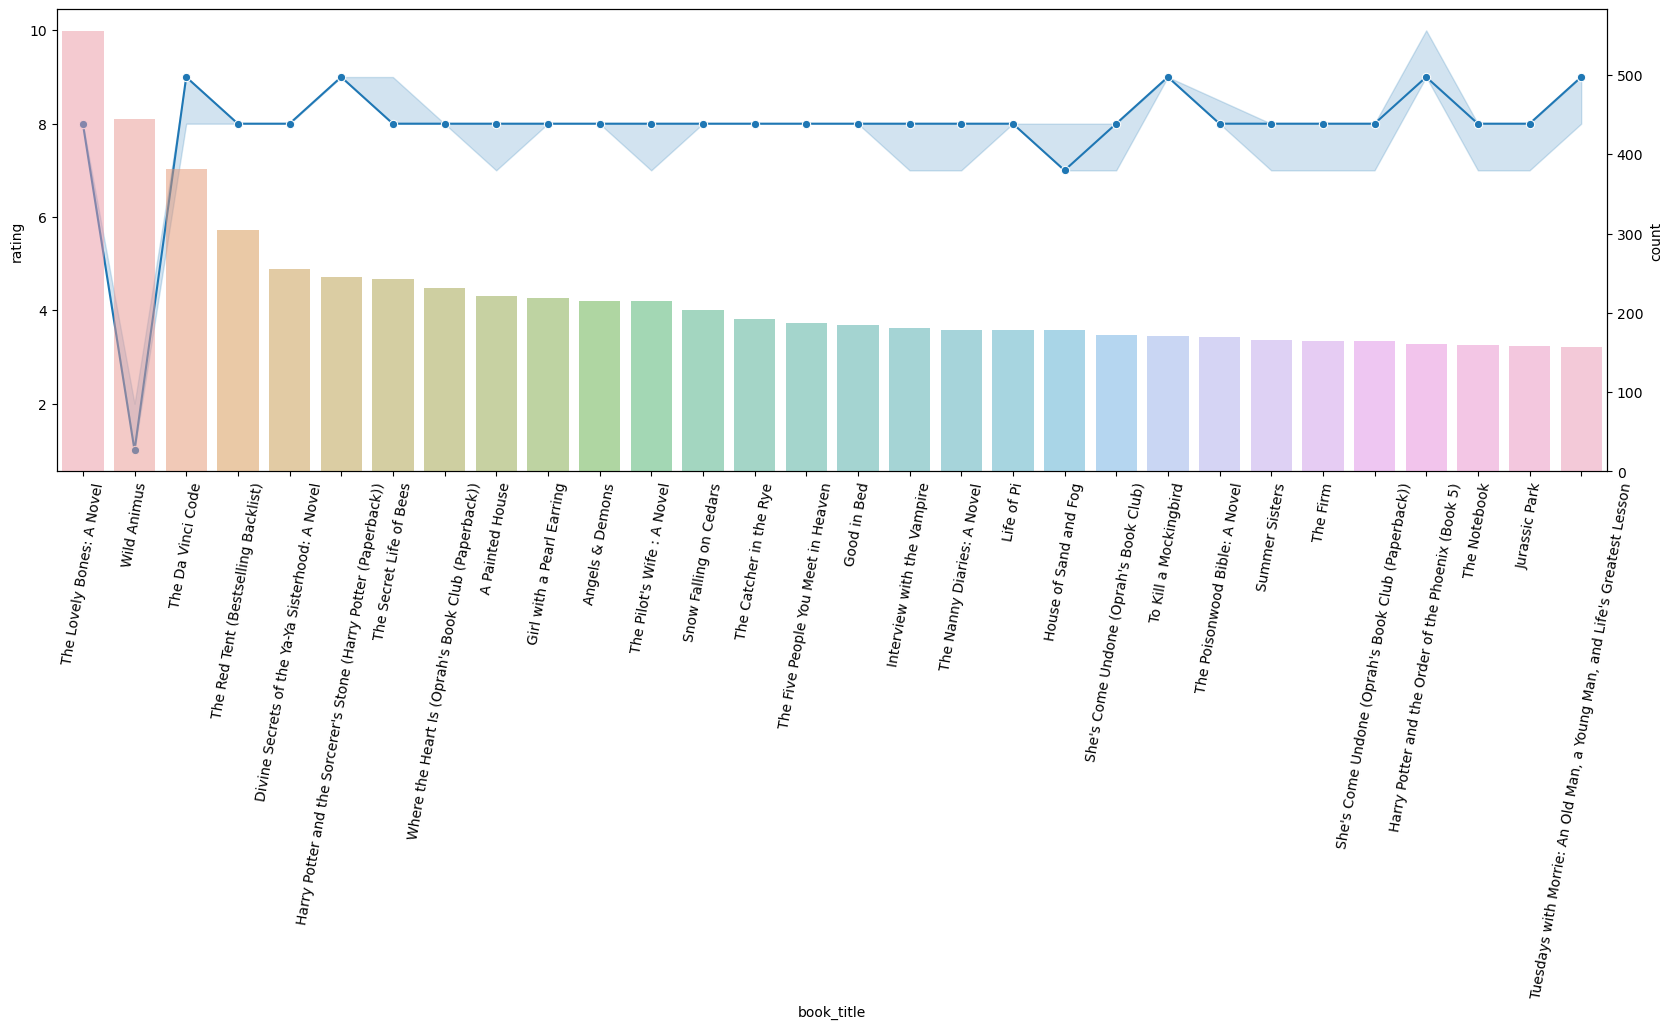

In [39]:
# popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
# popular_book = data[data['isbn'].isin(popular_book_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

- 뭐지.. wild animus에 1점 준 user들의 rating 분포를 살펴보려고 함

In [40]:
# wild animus에 1점 준 user id
rating_one_user_id = popular_book[popular_book['count'] == 445]['user_id']
# 걔네만 df 해서 mean값 봄
rating_one_user_df = data[data['user_id'].isin(rating_one_user_id)].groupby('user_id').mean().reset_index(drop=False)
rating_one_user_df = rating_one_user_df.sort_values(by='rating').reset_index(drop=True)

rating_one_user_df

,user_id,rating,year_of_publication
0,229635,1.000000,2004.000000
1,42032,1.000000,2004.000000
2,244923,1.000000,2004.000000
3,125889,1.000000,2004.000000
4,126851,1.000000,2004.000000
...,...,...,...
440,136747,9.538462,1998.615385
441,12272,9.882353,1993.529412
442,23021,10.000000,2004.000000
443,162528,10.000000,2004.000000


- 흠.. 좀 펴점이 짠 애들이 분포하고는 있으나 이걸 가지고 이상하다고 볼 수가 있나?

<AxesSubplot:xlabel='rating'>

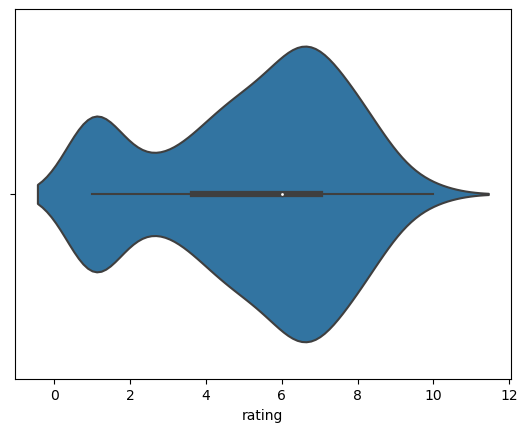

In [41]:
sns.violinplot(data = rating_one_user_df, x = 'rating')

- wild aniums의 별점 분포를 따로 봐야겠음
- 걍 진짜루.. 1점을ㅈ ㅜㄴ 애들이 많음

<AxesSubplot:>

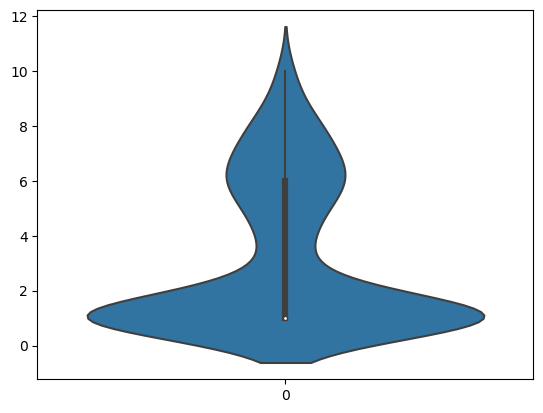

In [42]:
sns.violinplot(data[data['book_title'] == 'Wild Animus']['rating'].reset_index(drop=True))

### Rating 분포

<AxesSubplot:xlabel='rating'>

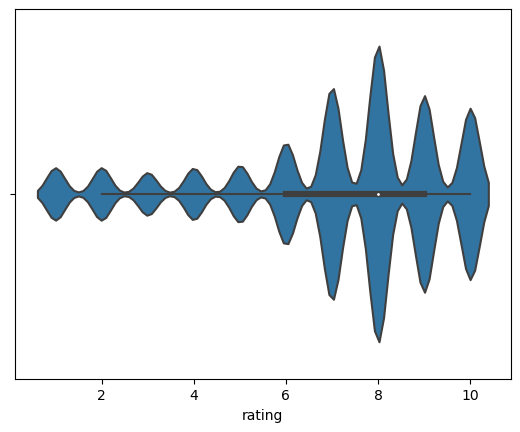

In [43]:
# 그냥 rating의 분포
sns.violinplot(data = data, x = 'rating')

/tmp/ipykernel_17913/606092147.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.groupby('user_id').mean()['rating'].reset_index(drop=True))


<AxesSubplot:xlabel='rating', ylabel='Density'>

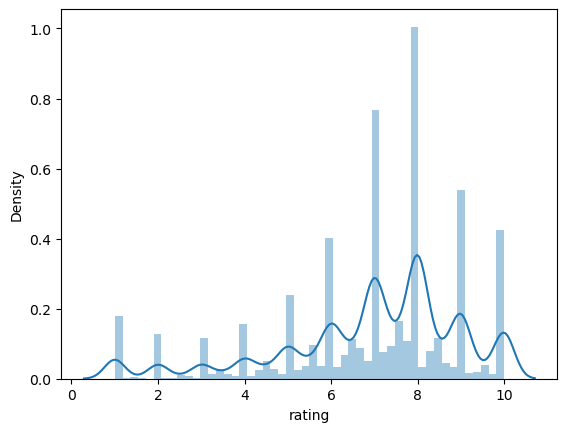

In [44]:
# user 별 rating 평균
sns.distplot(data.groupby('user_id').mean()['rating'].reset_index(drop=True))

### Rating에 대한 correlation

In [45]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [46]:
data.columns

Index(['user_id', 'isbn', 'rating', 'location_state', 'location_country',
       'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'img_path', 'category_high',
       'category_new'],
      dtype='object')

In [47]:
cramers_v(data['location_country'], data['rating'])

0.0386786815369926

In [48]:
cramers_v(data['book_title'], data['rating'])

0.1877094847382023

In [49]:
cramers_v(data['book_author'], data['rating'])

0.16730982914843956

In [50]:
cramers_v(data['publisher'], data['rating'])

0.09478192453715098

In [51]:
cramers_v(data['language'], data['rating'])

0.012086621981946854

In [52]:
cramers_v(data['category_high'], data['rating'])

0.0384281973095257

In [53]:
cramers_v(data['user_id'], data['rating'])

0.25400751883525396

In [188]:
# user의 평균 rating 개수 => 날릴까?...
np.quantile(data.groupby('user_id').count()['isbn'], 0.58)
data.groupby('user_id').count()['isbn'].mean()

5.051434998977435

In [225]:
sum(data.groupby('user_id').count()['isbn'] <= 1)

33909

In [196]:
ttmp = pd.merge(left = test, right = users, left_on = 'user_id', right_on = 'user_id', how = 'inner')
len(test) - len(ttmp) # 2647명이 처음 보는 user

2647

- 처음 보는 user에 대해서는 rule based로 접근해야 한다

In [198]:
ttmp = pd.merge(left = test, right = books, left_on = 'isbn', right_on = 'isbn', how = 'inner')
len(test) - len(ttmp) # 처음 보는 책은 없네

0

- 평가가 한개만 있는 애들은 다 날려볼까? => 킹석자의 주관으로 날려도 됨 영향력 없어보임

In [207]:
user_count = data.groupby('user_id').count()['isbn'].to_dict()

In [211]:
for i in range(len(data)):
    data.at[i, 'count'] = user_count[data['user_id'][i]]

In [227]:
len(data) - len(data[data['count']>1])

33909

In [229]:
data = data[data['count']>1].reset_index(drop=True)

In [230]:
ttmp = pd.merge(left = test, right = books, left_on = 'isbn', right_on = 'isbn', how = 'inner')
len(test) - len(ttmp) # 처음 보는 책은 없네

0

In [239]:
user_count_2 = ratings.groupby('user_id').count()['isbn'].to_dict()
ratings_origin = ratings.copy()
for i in range(len(ratings)):
    ratings.at[i, 'count'] = user_count_2[ratings['user_id'][i]]
ratings = ratings[ratings['count']>1].reset_index(drop=True)

In [240]:
len(ratings_origin)

306795

In [242]:
ratings

,user_id,isbn,rating,count
0,8,0002005018,4,7.0
1,67544,0002005018,7,7.0
2,210926,0002005018,9,5.0
3,219008,0002005018,7,26.0
4,263325,0002005018,5,40.0
...,...,...,...,...
272173,278843,0743525493,7,13.0
272174,278851,067161746X,6,12.0
272175,278851,0884159221,7,12.0
272176,278851,0912333022,7,12.0


In [241]:
len(ratings)

272178

In [ ]:
r